In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
from scipy.special import erf
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from scipy.stats import multivariate_normal,kstest,norm,t
from scipy.interpolate import interp1d
from scipy.special import erf
from joblib import Parallel, delayed
from scipy.optimize import minimize
from statsmodels.distributions.empirical_distribution import ECDF
from pandas.tseries.offsets import Day, BDay
from datetime import date
import matplotlib.ticker as mtick
#from pypfopt_risk_models import *
import os
import h5py
from joblib import wrap_non_picklable_objects
from hmmlearn import hmm
Ncores=6
#plt.style.use('stylesheet')
plt.style.use('MNRAS_stylesheet')

In [2]:
# Helper functions
# Gaussian PDF
def gauss_pdf(x, mu,var):
    sigma = np.sqrt(var)
    return norm(scale=sigma, loc=mu).pdf(x)

# Gaussian CDF
def gauss_cdf(x,mu,sigma):
    return 0.5*(1+erf((x-mu)/(sigma*np.sqrt(2))))

def gauss_icdf(x,mu,sigma):
    return norm.ppf(x,loc=mu,scale=sigma)


def KS_test(returns, cdf1, cdf2):
    p1 = kstest(returns, cdf1)[1]
    p2 = kstest(returns, cdf2)[1]
    return p1,p2

def load_timeseries():
    # Get filenames using glob
    fnames = glob('./timeseries/*csv')
    for f in fnames:
        newdf = pd.read_csv(f)[['Date','Close']]
        newdf = newdf.set_index('Date')
        newdf.index = pd.to_datetime(newdf.index)
        newdf.columns = [f.split('/')[-1].split('.csv')[0]]
        try:
            df = df.join(newdf)
        except:
            df = newdf
    df = df.dropna()
    return df

def plot_timeseries():
    # First plot of all timeseries
    (df / df.iloc[0]*100).plot(lw=1)
    plt.legend(frameon=1)
    plt.ylabel('Normalized stock index price')
    plt.tight_layout()
    plt.savefig('Prices.pdf',bbox_inches='tight')
    
# VaR estimation using variance-covariance matrix
class dataconversion():
    def __init__(self):
        return
    
    def to_log_ret(self, df):
        """Convert prices to log returns"""
        log_ret = np.log(df/df.shift(1))
        return log_ret.iloc[1:,:]
    
def qq_plot(returns):
    stocks = returns.columns
    def order(data, sample_size):
        qq = np.ones([sample_size, 2])
        np.random.shuffle(data)
        qq[:, 0] = np.sort(data[0:sample_size])
        qq[:, 1] = np.sort(np.random.normal(size = sample_size))
        return qq
    
    for stock in stocks:
        measurements = returns[stock]
        qq = order(measurements/np.std(measurements), len(measurements))
        plt.scatter(qq[:,1],qq[:,0],s=0.8,label=stock)
    plt.xlabel('Theoretical quantiles')    
    plt.ylabel('Sample quantiles')
    plt.legend(frameon=1)
    plt.plot([-4,4],[-4,4],color='black',lw=0.5,ls='--')
    plt.tight_layout()
    plt.savefig('qq_plot.pdf',bbox_inches='tight')
    plt.show()
    
def CDFs(returns):
    stocks = returns.columns
    # Plot CDFs to check normality
    fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(6,3.4))
    axes = axes.flatten()
    for i,stock in enumerate(stocks):
        empirical_CDF = ECDF(returns[stock])
        ax = axes[i]
        ax.plot(empirical_CDF.x,empirical_CDF.y,lw=1,color='tomato',label='ECDF')
        x = np.linspace(empirical_CDF.x[1],empirical_CDF.x[-2], 1000)
        fitted_cdf = gauss_cdf(x, model.means_[0,i], np.sqrt(model.covars_[0,i,i]))
        ax.plot(x, fitted_cdf,color='black',lw=0.7,ls='--',label=r'$\mathcal{N}$-CDF')
        ax.set_xlim(-0.07,0.07)
        ax.set_title(stock,y=0.2,x=0.7)
        ax.legend(frameon=1)
    for i in [3,4,5]:
        axes[i].set_xlabel('Return')
    for i in [0,3]:
        axes[i].set_ylabel('CDF')
    axes[-1].axis('off')
    plt.tight_layout()
    plt.savefig('CDF_comparison.pdf', bbox_inches='tight')
    plt.show()


In [101]:
df = load_timeseries()
# Estimate value of cash portfolio
cashaccount = np.cumprod((1+df.US3month/25200))
df['US3month'] = cashaccount
# Give new name in dataframe
df = df.rename({'US3month':'Cash'},axis=1)
# Sort according to return for plotting purposes
df = df[((df/df.iloc[0]).iloc[-1]).sort_values(ascending=False).index]

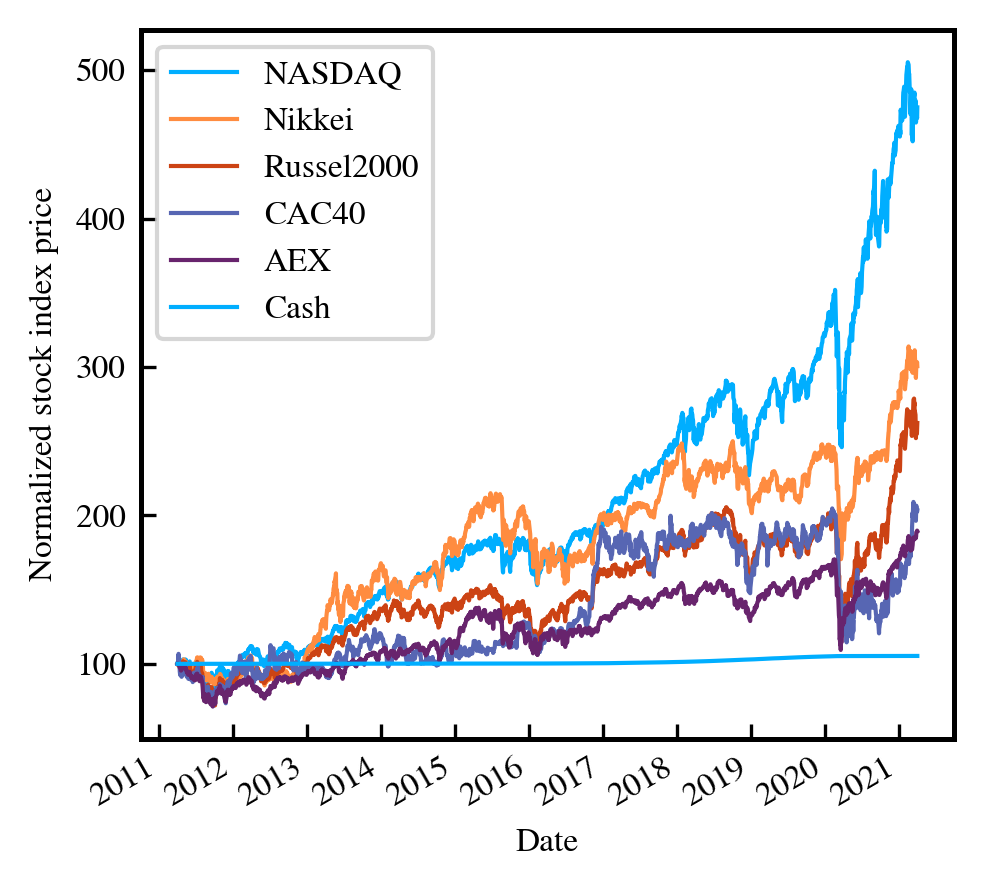

In [102]:
plot_timeseries()

In [113]:
# Convert prices to log returns
DC = dataconversion()
returns = DC.to_log_ret(df)
returns = returns.iloc[:,:-1]
stocks = returns.columns

In [114]:
returns

,NASDAQ,Nikkei,Russel2000,CAC40,AEX
Date,,,,,
2011-04-04,-0.000147,0.001081,0.003054,0.006215,-0.001192
2011-04-05,0.000717,-0.010690,0.004640,0.032145,-0.000136
2011-04-06,0.003087,-0.003248,0.001007,0.026905,0.001841
2011-04-07,-0.001315,0.000684,-0.005553,-0.021466,-0.006106
2011-04-08,-0.005638,0.018302,-0.010116,-0.031687,-0.001226
...,...,...,...,...,...
2021-03-25,0.001217,0.011354,0.022630,0.020778,-0.001167
2021-03-26,0.012333,0.015433,0.017419,0.029865,0.016340
2021-03-29,-0.006037,0.007098,-0.028677,-0.018692,0.001893


In [105]:
from hmmlearn import hmm
model = hmm.GaussianHMM(n_components=1, covariance_type="full")
model.fit(returns)

GaussianHMM(covariance_type='full')

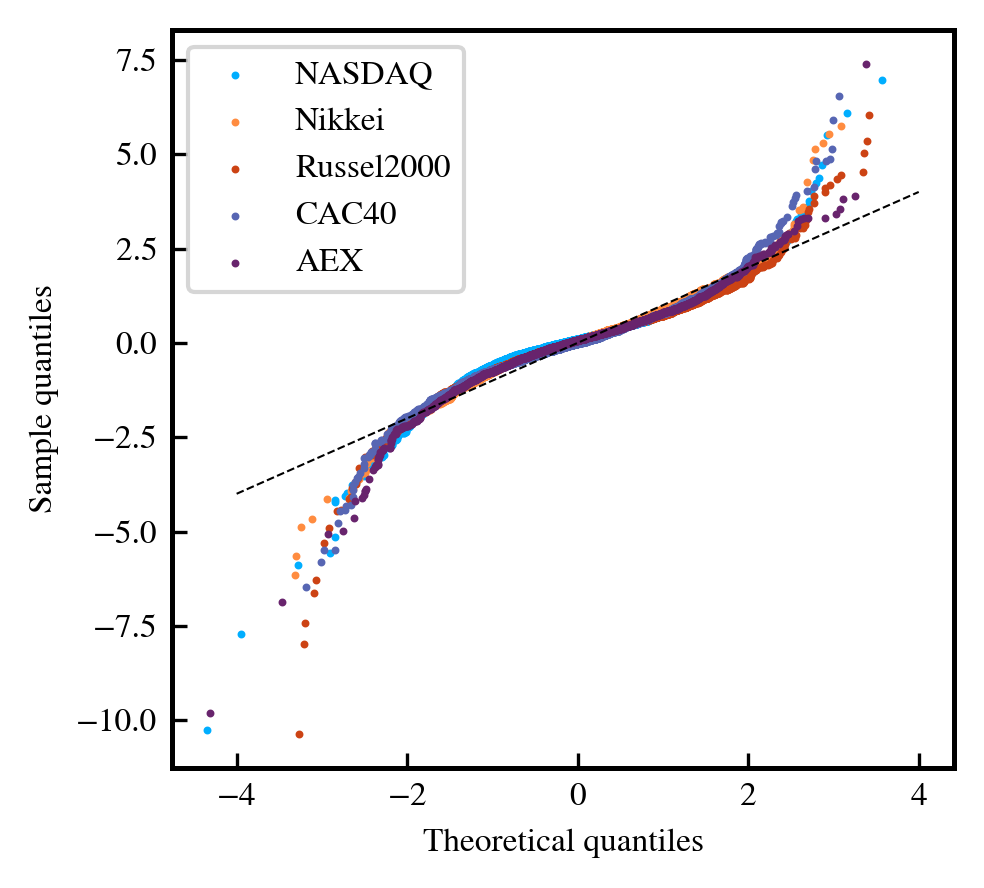

In [107]:
#qq_plot(returns.drop('Cash',axis=1))
qq_plot(returns)

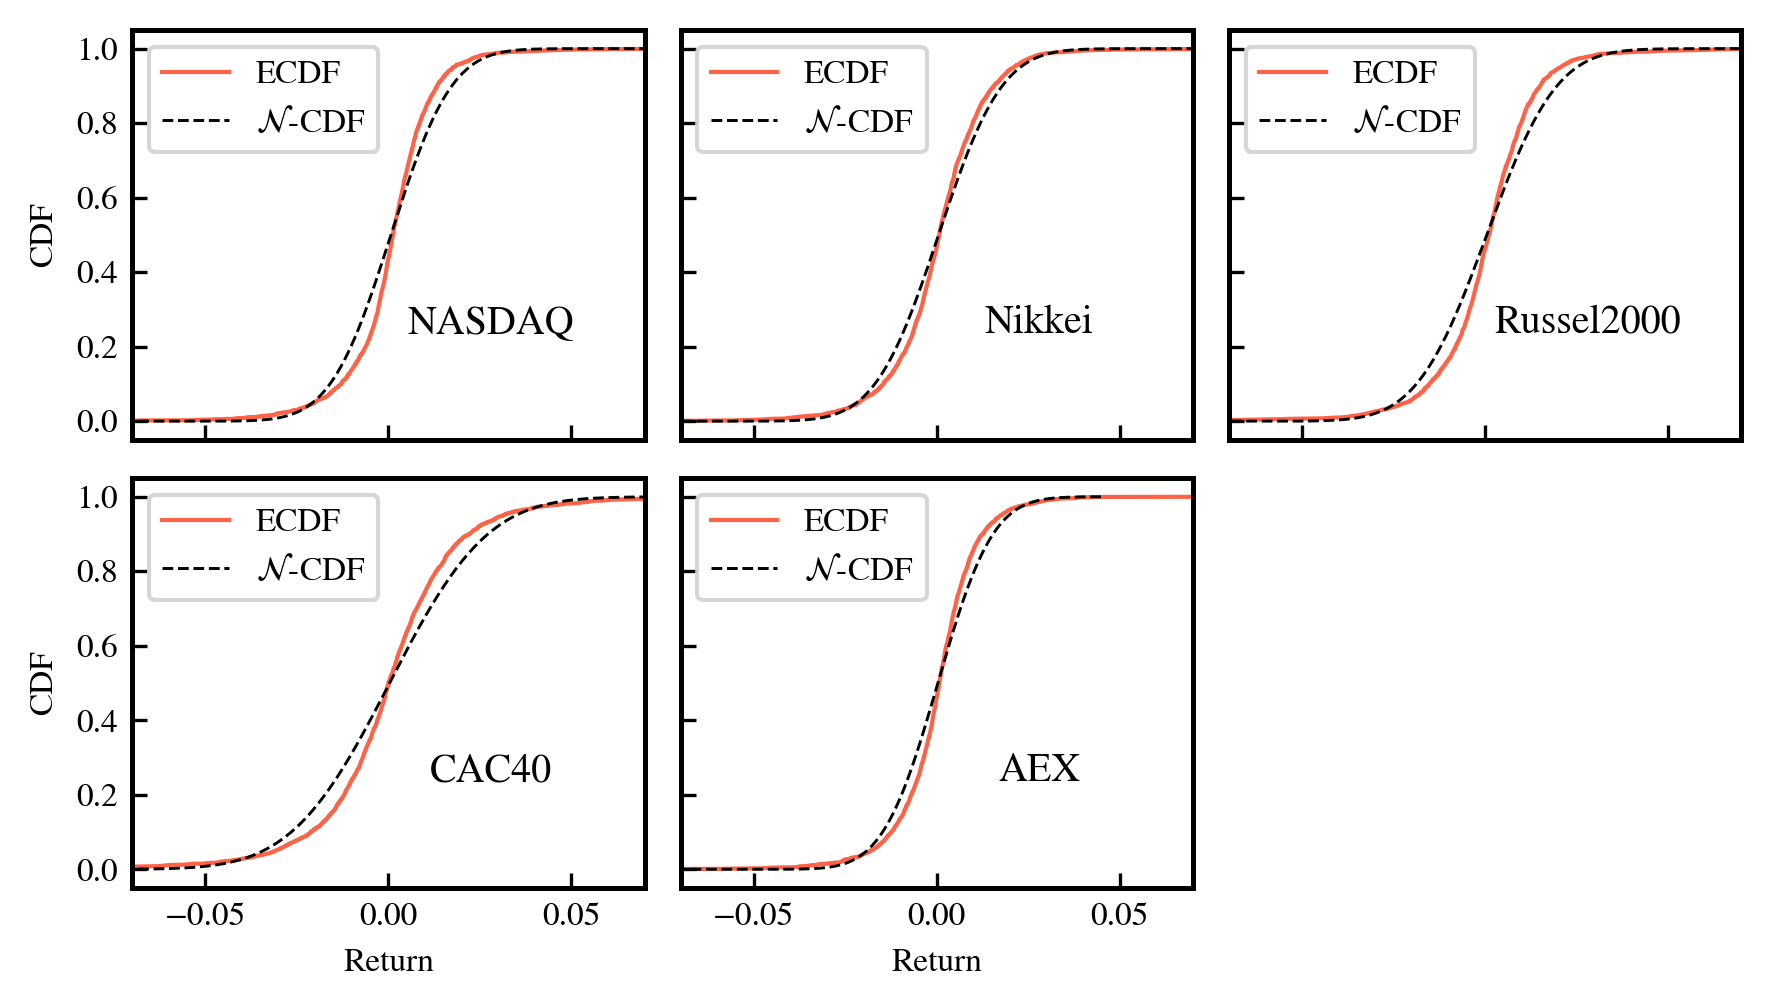

In [109]:
#CDFs(returns.drop('Cash',axis=1))
CDFs(returns)

In [110]:
# Estimate covariance matrix
# Option 1: normal covariance matrix
covmat1 = returns.cov()
# Option 2: Ledoit Wolf shrinkage
from sklearn.covariance import LedoitWolf
covmat2 = LedoitWolf().fit(returns)
covmat2 = pd.DataFrame(covmat2.covariance_,index=covmat1.index, columns = covmat1.columns)

In [115]:
# Estimate covariance matrix over first two years
init_covmat = returns.loc[:'2013-03'].cov()
covmats = np.zeros((1+len(returns.loc['2013-03':]), len(stocks), len(stocks)))
covmats[0,:,:] = init_covmat
# Iteratively update covmat
theta=0.04
for i,(date, X) in enumerate(returns.loc['2013-03':].iterrows()):
    X = X.values
    X = X - returns.mean().values
    X = X.reshape(-1,1)
    covmats[i+1] = theta * covmats[i] + (1-theta) * np.dot(X,X.T)

In [116]:
# Now estimate VaR 
alpha = 0.01
sigmas = np.array([np.sqrt(np.diag(covmats[w,:,:])) for w in range(len(covmats))])
VaR = +returns.mean().values + norm.ppf(1-alpha)*sigmas
ES  = +returns.mean().values + 1/alpha * norm.pdf(norm.ppf(alpha))*sigmas

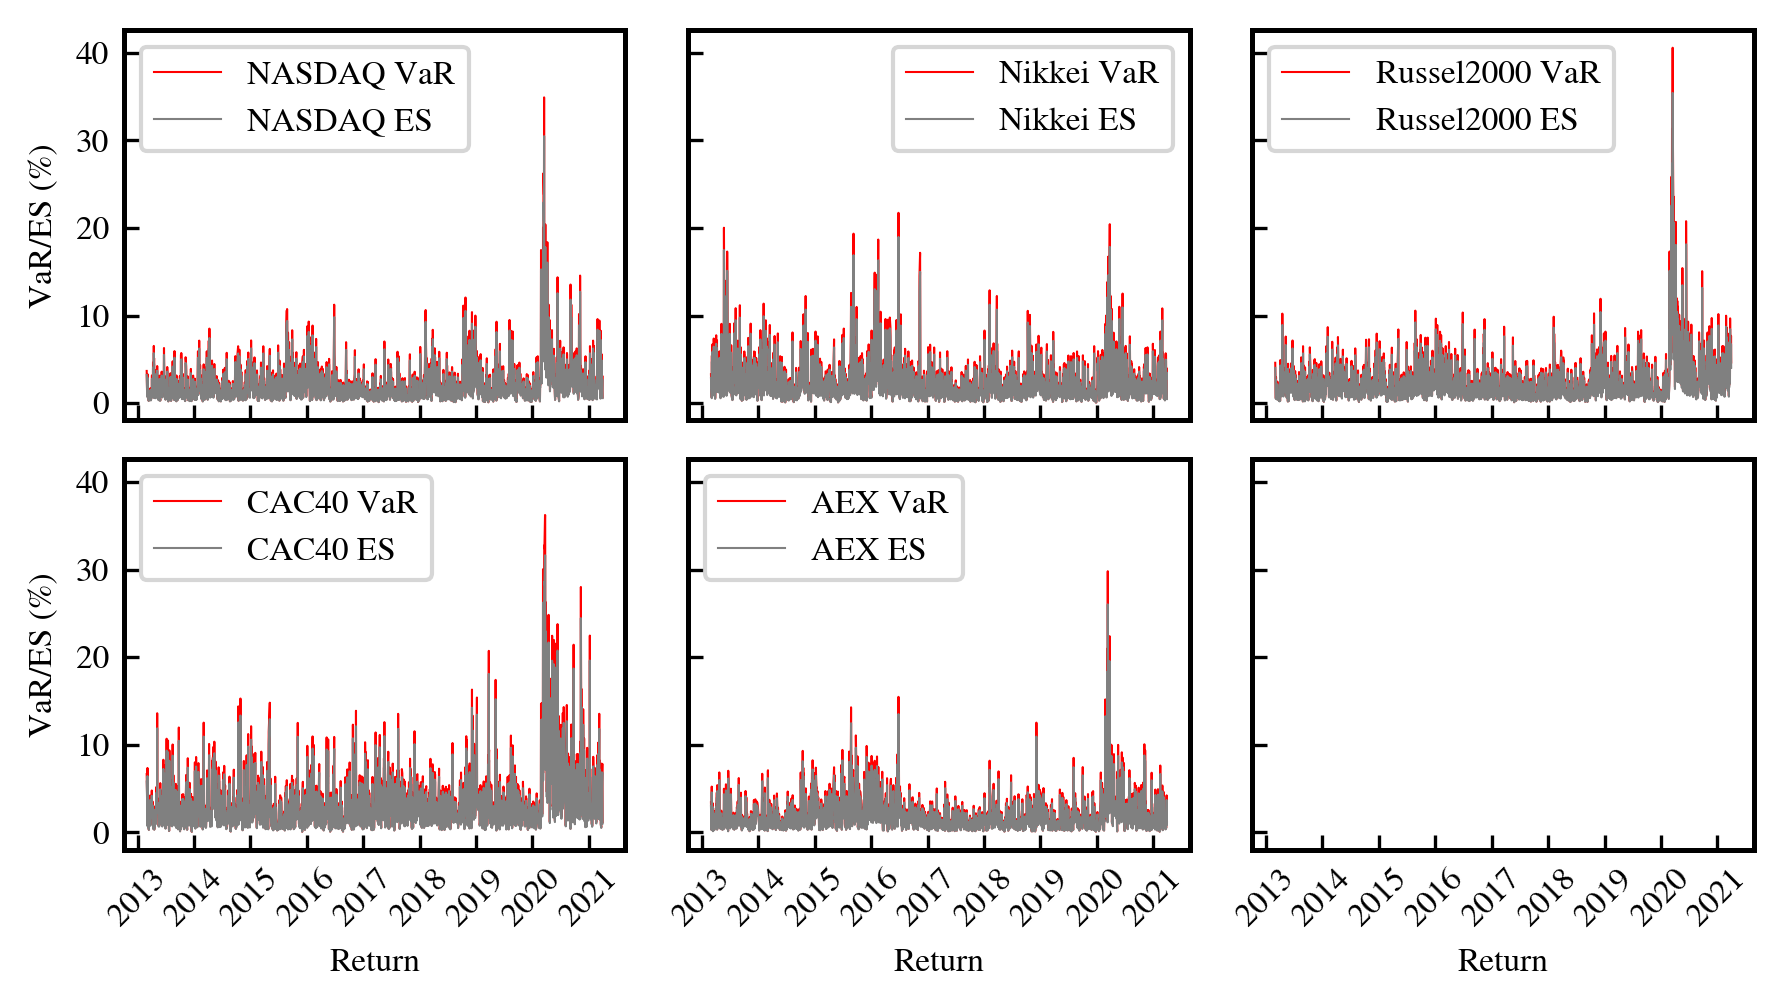

In [117]:
# Plot CDFs to check normality
fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(6,3.4))
axes = axes.flatten()
for i,stock in enumerate(stocks):
    var = VaR[:-1,i]*100
    es  = ES[:-1,i]*100
    ax = axes[i]
    ax.plot(returns.loc['2013-03':].index, es,lw=0.5,color='red',label=stock+' VaR')
    ax.plot(returns.loc['2013-03':].index, var,lw=0.5,color='grey',label=stock+' ES')
    
    ax.legend(frameon=1)
    
for i in [3,4,5]:
    axes[i].set_xlabel('Return')
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45 )
for i in [0,3]:
    axes[i].set_ylabel('VaR/ES (%)')
plt.tight_layout()
plt.savefig('ES_VaR_covariance.pdf', bbox_inches='tight')
plt.show()

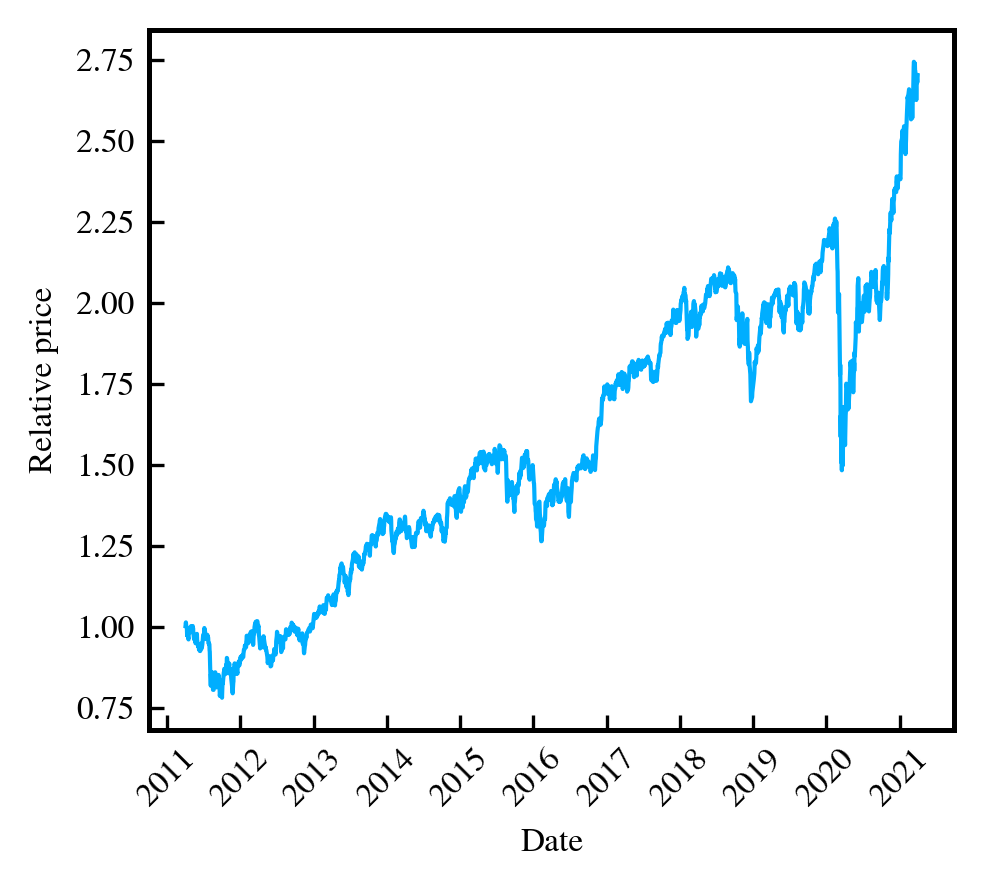

In [119]:
# We can also consider a portfolio of all six indices
weights = np.ones(5)/5
portfolio = np.dot(weights, returns.T)
plt.plot(returns.index,np.exp(np.cumsum(portfolio)),lw=1)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Relative price')
plt.tight_layout()
plt.savefig('price_equal_portfolio.pdf',bbox_inches='tight')

In [120]:
# Portfolio variance is given by 
port_var = lambda w,Omega: np.dot(np.dot(w.T, Omega), w)
# We can again iteratively determine this for the portfolio
portfolio_variance = np.array([port_var(weights, covmats[w]) for w in range(len(covmats))])
# Convert variance to VaR 
VaR = np.sqrt(portfolio_variance) * norm.ppf(1-alpha) + np.dot(weights, returns.mean())
ES = np.sqrt(portfolio_variance) * 1/alpha * norm.pdf(norm.ppf(alpha)) + np.dot(weights, returns.mean())

VaR = pd.Series(100*VaR[:-1], index=returns.loc['2013-03':].index)
ES  = pd.Series(100*ES[:-1], index=returns.loc['2013-03':].index)

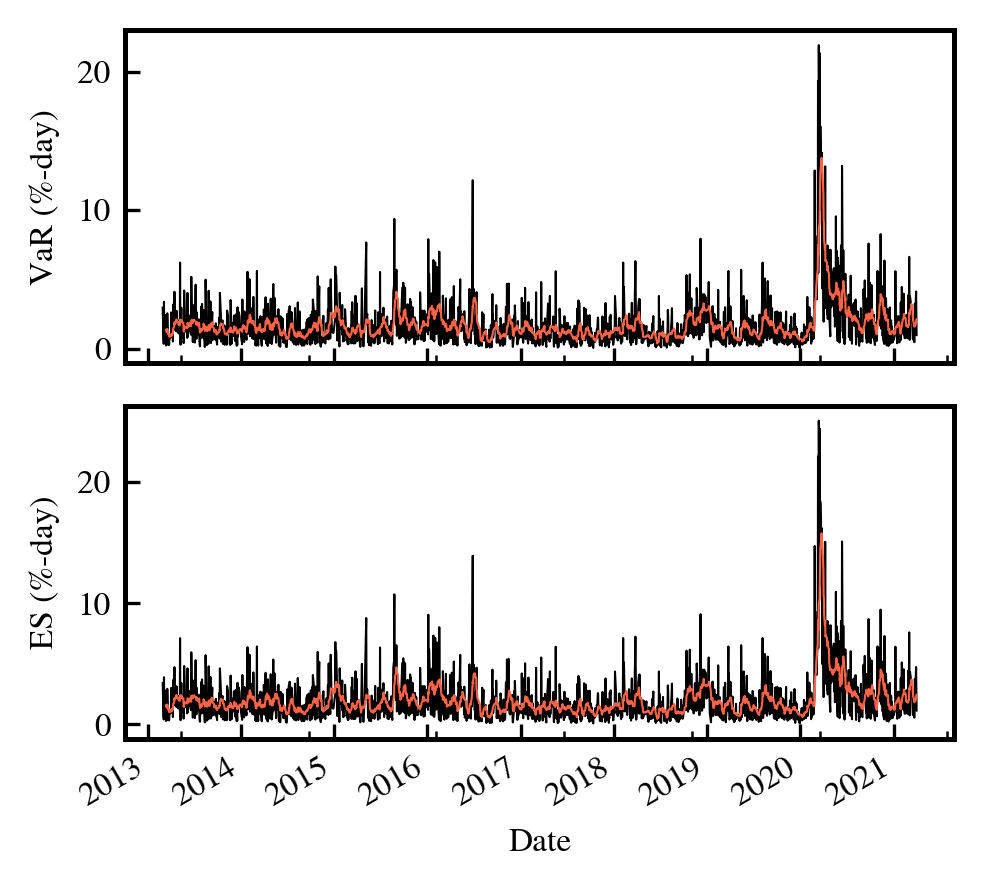

In [121]:
fig, axes = plt.subplots(nrows=2,sharex=True)
axes[0].plot(VaR.index, VaR.values,lw=0.5,color='black')
VaR.rolling(10).mean().plot(ax=axes[0],lw=0.5,color='tomato')
axes[1].plot(ES.index, ES.values,lw=0.5,color='black')
ES.rolling(10).mean().plot(ax=axes[1],lw=0.5,color='tomato')
axes[0].set_ylabel('VaR (%-day)')
axes[1].set_ylabel('ES (%-day)')
plt.tight_layout()
plt.savefig('Portfolio_VaR_ES.pdf', bbox_inches='tight')

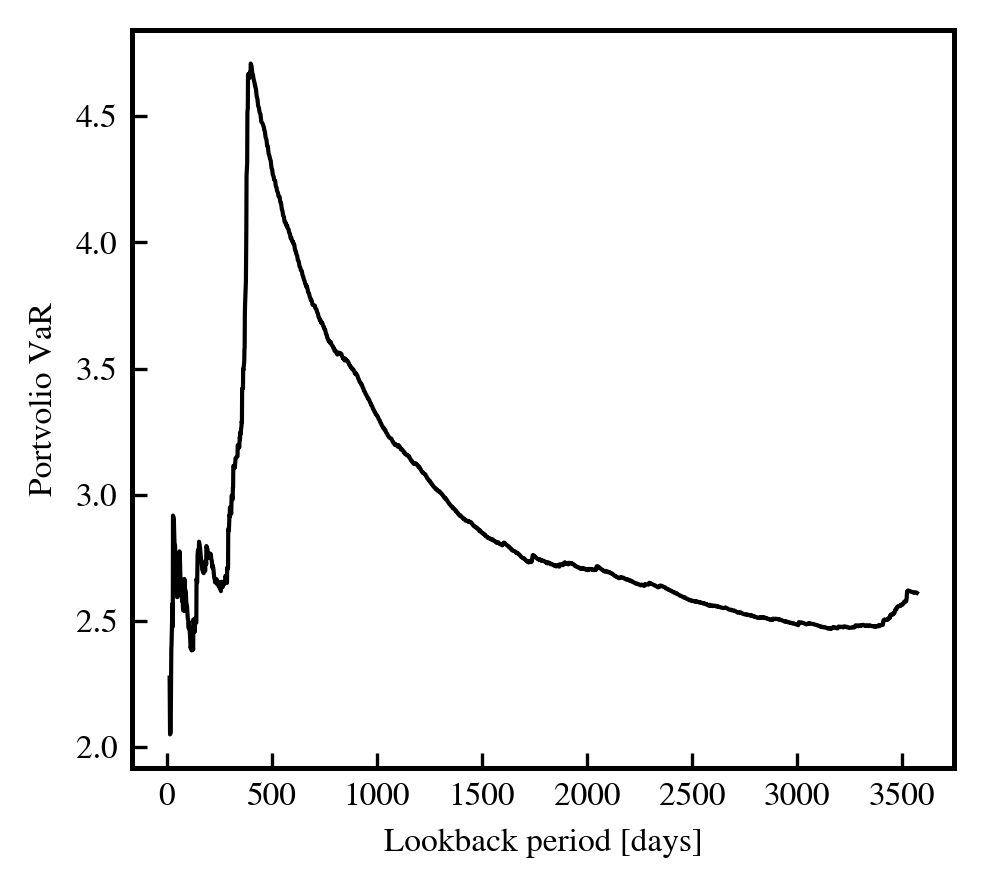

In [122]:
# We can also do a static VaR estimation based on different amounts of history
VaRs = []
lookbacks = []
for startdate in returns.index[:-10]:
    # Get subdf
    subdf = returns.loc[startdate:]
    # Get covariance matrix and mean
    sub_covmat = subdf.cov()
    sub_means  = subdf.mean()
    VaR = np.sqrt(port_var(weights, sub_covmat))* norm.ppf(1-alpha) + np.dot(weights, sub_means)
    VaRs.append(100*VaR)
    lookbacks.append((returns.index[-1] - startdate).days)
plt.plot(lookbacks[50:], VaRs[50:],lw=1,color='black')
plt.xlabel('Lookback period [days]')
plt.ylabel('Portvolio VaR')
plt.tight_layout()
plt.savefig('Portfolio_VaR_lookbackperiod.pdf', bbox_inches='tight')

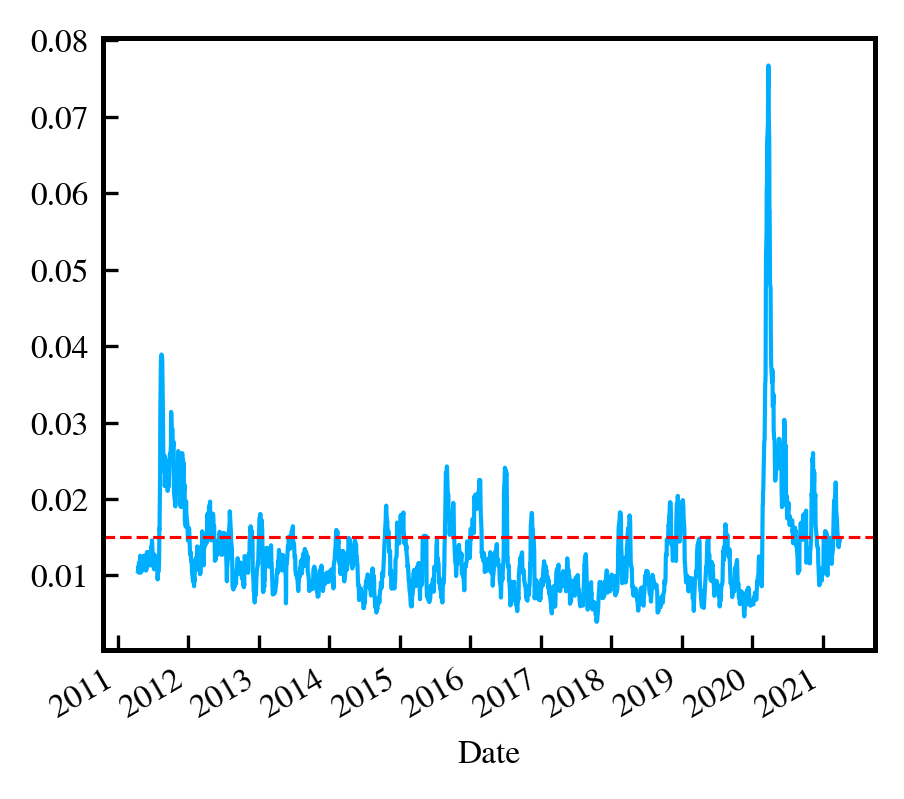

0.04243463351907415
0.015002143163309044


In [123]:
# Backtesting
# We can also do a static VaR estimation based on different amounts of history
returns.rolling(10).std().mean(axis=1).plot(lw=1)
plt.axhline(0.015,ls='--',color='red',lw=0.75)
returns_wo_stress = returns[returns.rolling(10).std().mean(axis=1)<0.015]
portfolio_variance1 = port_var(weights, returns_wo_stress.cov())
portfolio_variance2 = port_var(weights, returns.cov())
VaR1 = np.sqrt(portfolio_variance1) * norm.ppf(1-alpha) + np.dot(weights, returns_wo_stress.mean())
VaR2 = np.sqrt(portfolio_variance2) * norm.ppf(1-alpha) + np.dot(weights, returns.mean())
plt.show()

# Backtest:
portfolio_returns = np.dot(weights, returns.T)
print(np.mean(portfolio_returns < -VaR1))
print(np.mean(portfolio_returns < -VaR2))

/home/luuk/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.645e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/luuk/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.804e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/luuk/anaconda3/lib/python3.8/site-packages/arch/univariate

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14168.107615452096
            Iterations: 19
            Function evaluations: 102
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14518.327349103833
            Iterations: 18
            Function evaluations: 108
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14471.05284565658
            Iterations: 21
            Function evaluations: 123
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: 15391.445684690116
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14059.763878361699
            Iterations: 21
            Function eva

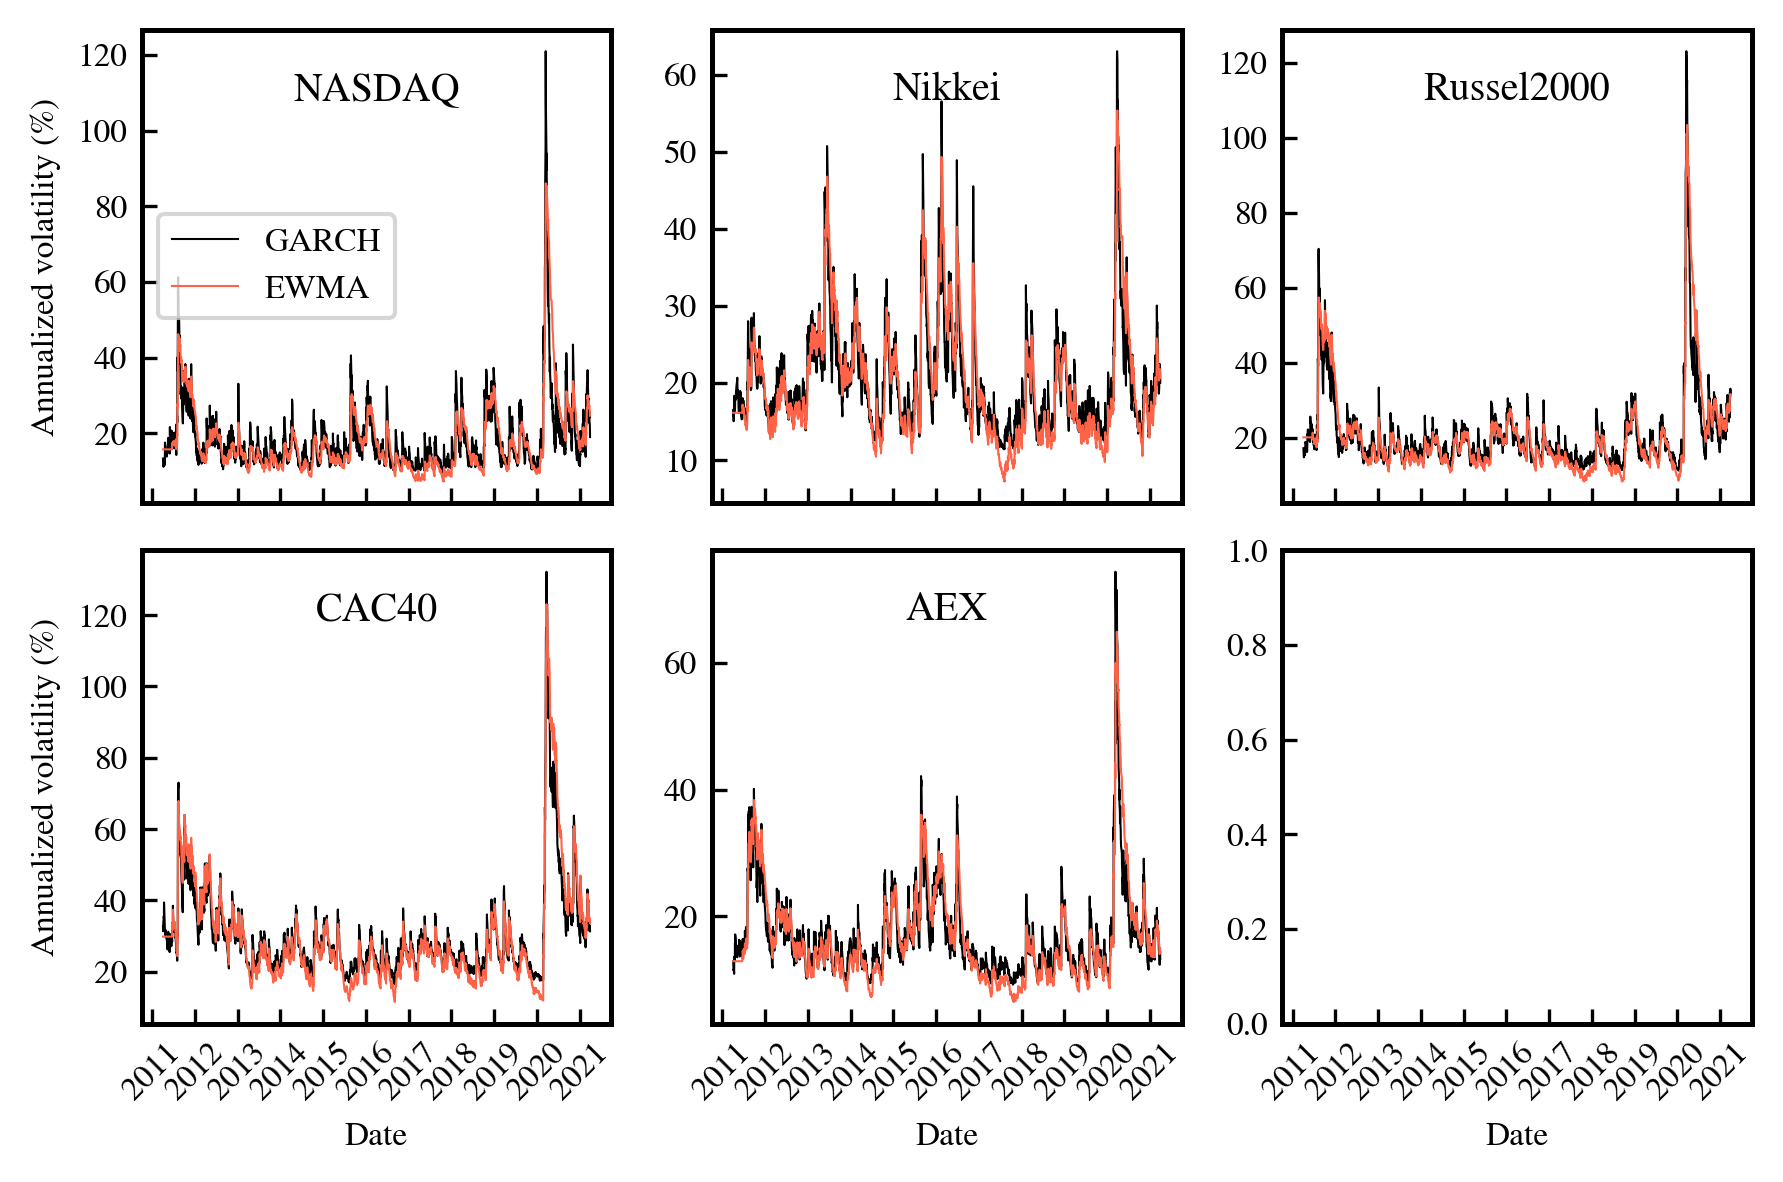

In [124]:
# Filtered historic simulation with EWMA
from arch import arch_model
fig,axes = plt.subplots(2,3,figsize=(6,4),sharex=True)
axes=axes.flatten()
residuals    = pd.DataFrame(index=returns.index)
volatilities = pd.DataFrame(index=returns.index)
for i,asset in enumerate(returns.columns):
    ret = returns[asset].dropna()
    dates = ret.index
    ret = ret.values.flatten()
    # Scaling to improve GARCH estimation
    C = 4
    ret = ret * 10**C
    # Fit constant mean GARCH(1,1) model
    am = arch_model(ret, p=1,q=1)
    res = am.fit(update_freq=0,)
    # Get conditional volatilities
    volas = res.conditional_volatility/1e4
    # Estimate empirical distribution of zt
    zt = (ret-res.params.mu) / volas
    axes[i].set_title(returns.columns[i], y=0.8)
    axes[i].plot(dates,np.sqrt(252)*100*volas,color='black',lw=0.5,label='GARCH')
    # EWMA
    EWMA_var = np.zeros(len(ret))
    EWMA_var[:50] = returns[asset].iloc[:50].var()*1e8
    for j in range(50,len(ret)):
        EWMA_var[j] = 0.94 * EWMA_var[j-1] + (1-0.94)*ret[j-1]**2
    EWMA_var = EWMA_var/1e8
    axes[i].plot(dates,np.sqrt(252)*100*np.sqrt(EWMA_var),color='tomato',lw=0.5,label='EWMA')
    #axes[i].set_ylim(0,0.6)
    #axes[i].set_xlim(-8,8)
    #
axes[0].legend(frameon=1,loc='center left')
for i in [3,4,5]:
    axes[i].set_xlabel('Date')
    #axes[i].set_xticklabels(axes[i].get_xticklabels(),rotation=45)
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45 )
for i in [0,3]:
    axes[i].set_ylabel('Annualized volatility (%)')
plt.tight_layout()

plt.savefig('EWMA_GARCH.pdf',dpi=500)
plt.show()

In [147]:
#FHS to obtain VaR predictions
# Filtered historic simulation with EWMA
timeframe = 2*252 #days
ewma_lambda = 0.94
output_df = pd.DataFrame({'VaR1':np.nan*np.ones(len(returns)),'Var25':np.nan*np.ones(len(returns))},index=returns.index)
for time_iter in range(0,len(returns)-timeframe):
    # Get 5 year range of data 
    subreturns = returns.iloc[time_iter:time_iter+timeframe]
    residuals    = pd.DataFrame(index=subreturns.index)
    sigma_preds = {}
    for i,asset in enumerate(subreturns.columns):
        ret = subreturns[asset].dropna()
        dates = ret.index
        ret = ret.values.flatten()
        # Estimate EWMA model
        EWMA_var = np.zeros(len(ret))
        EWMA_var[:50] = np.var(ret[:50])
        for j in range(50,len(ret)):
            EWMA_var[j] = ewma_lambda * EWMA_var[j-1] + (1-ewma_lambda)*ret[j-1]**2
        EWMA_vol = np.sqrt(EWMA_var)
        # Predict volatility one day ahead
        sigma_pred = np.sqrt(ewma_lambda*EWMA_var[-1] + (1-ewma_lambda)*ret[-1]**2)
        sigma_preds[asset] = sigma_pred
        # Estimate empirical distribution of zt
        zt = (ret-ret.mean()) / EWMA_vol
        # Save residuals
        residuals.loc[dates,asset] = zt
    # Simulate returns for day t+1
    simulated_returns = residuals* sigma_preds
    # Get portfolio returns
    portfolio = np.dot(weights,simulated_returns.T)
    VaR1 = np.percentile(portfolio,1)
    VaR25 = np.percentile(portfolio,2.5)
    #ES = np.mean(portfolio[portfolio<VaR])
    output_df.loc[returns.iloc[time_iter:time_iter+timeframe+1].index[-1]] = [VaR1,VaR25]

In [148]:
output_df['portfolio_return'] = np.dot(weights,returns.T)

In [152]:
count_VaR_violations = output_df.dropna()
(count_VaR_violations['portfolio_return']<count_VaR_violations['VaR1']).sum()

20

In [151]:
(count_VaR_violations['portfolio_return']<count_VaR_violations['Var25']).sum()

47

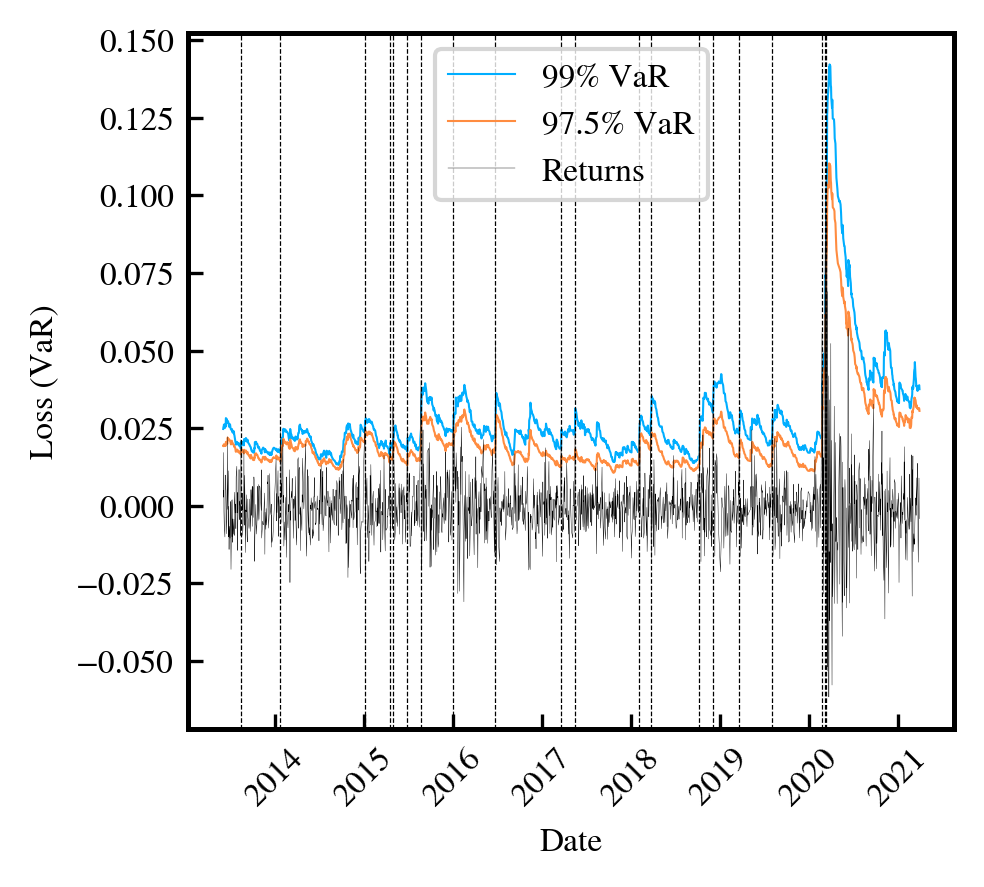

In [153]:
plt.plot(output_df.index[timeframe:],-1*output_df.VaR1[timeframe:],lw=0.5,label='99% VaR')
plt.plot(output_df.index[timeframe:],-1*output_df.Var25[timeframe:],lw=0.5,label='97.5% VaR')
plt.plot(returns.index[timeframe:],-1*np.dot(weights,returns.T)[timeframe:],lw=0.1,color='black',label='Returns')
for i in count_VaR_violations.index[count_VaR_violations['portfolio_return']<count_VaR_violations['VaR1']]:
    plt.axvline(i,lw=0.3,color='black',ls='--')
plt.xticks(rotation=45)
plt.legend(frameon=1)
plt.ylabel('Loss (VaR)')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('FHS_VaR.png',dpi=600)

In [88]:
# Check performance of square root t
# Step 1: sample 5 day sets of returns
# Generate sets of 5 random days
Ndays = np.arange(5,252,10)
onedayVaR = -1*np.percentile(np.dot(weights,returns.T),1)
errs = []
VaRs = []
sq_VaRs = []
for day in Ndays:
    days = np.random.randint(low=0,high=len(returns),size=(500000,day))
    # Get cumulative returns for these days
    portfolio = np.dot(weights,returns.T)
    meanret = np.mean(portfolio)
    portfolio = portfolio[days]
    portfolio = np.sum(portfolio,axis=1)
    # Get empirical VaR
    VaR = -1*np.percentile(portfolio,1)
    sq_root_time_VaR = np.sqrt(day) * onedayVaR
    err = np.abs(VaR - sq_root_time_VaR)
    
    errs.append(err)
    VaRs.append(VaR)
    sq_VaRs.append(sq_root_time_VaR)
    

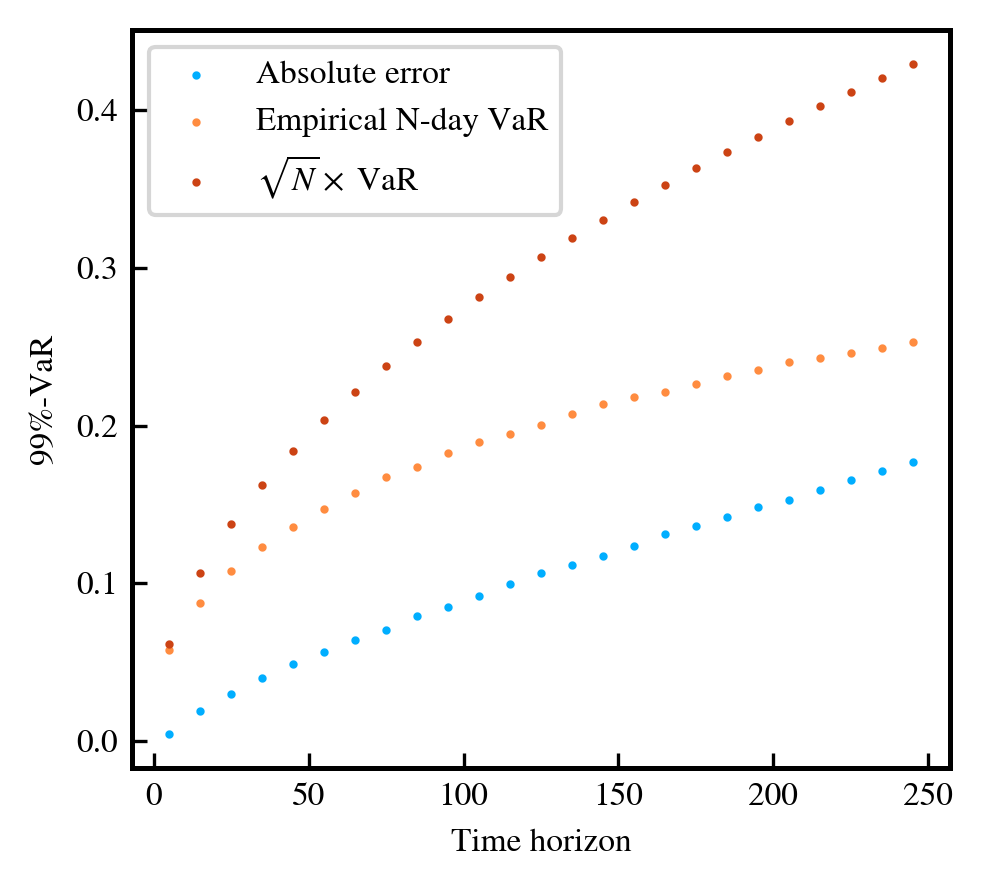

In [89]:
plt.figure()
plt.scatter(Ndays,errs,s=1,label='Absolute error')
plt.scatter(Ndays,VaRs,s=1,label='Empirical N-day VaR')
plt.scatter(Ndays,sq_VaRs,s=1,label=r'$\sqrt{N}\times$ VaR')
plt.legend(loc='best',frameon=1)
plt.xlabel('Time horizon')
plt.ylabel('99%-VaR')
plt.tight_layout()
plt.savefig('Testing_squareroot_rule.pdf')

In [90]:
Ndays = np.array([5,10])
onedayVaR = -1*np.percentile(np.dot(weights,returns.T),1)
df = pd.DataFrame({'Number of days':Ndays, 'Simulated VaR':[0,0],'Square Root VaR':[0,0]}).set_index('Number of days')
for day in Ndays:
    days = np.random.randint(low=0,high=len(returns),size=(500000,day))
    # Get cumulative returns for these days
    portfolio = np.dot(weights,returns.T)
    meanret = np.mean(portfolio)
    portfolio = portfolio[days]
    portfolio = np.sum(portfolio,axis=1)
    # Get empirical VaR
    VaR = -1*np.percentile(portfolio,1)
    sq_root_time_VaR = np.sqrt(day) * onedayVaR
    df.loc[day] = [VaR, sq_root_time_VaR]
print((df*100).round(3).to_latex(bold_rows=True))

\begin{tabular}{lrr}
\toprule
{} &  Simulated VaR &  Square Root VaR \\
\textbf{Number of days} &                &                  \\
\midrule
\textbf{5             } &          5.709 &            6.138 \\
\textbf{10            } &          7.505 &            8.680 \\
\bottomrule
\end{tabular}

